In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Modeling
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [4]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + CS1 + CS3 + CS7",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Decision Tree",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [5]:
df = pd.read_csv("../../../../../data/processed/partner_i-Oficial/cpvari.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [6]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",       
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        "LOI"
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [7]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "max_depth": 3,
    "random_state": SEED,
    "splitter": "best",
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 59 samples each
    2. 90% train (535 samples each fold)
    3. 10% test (59 samples each fold)
<b>Total:</b> 100 models<br>

In [9]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.955 (0.107)
MAE: -0.744 (0.098)
MAPE: -0.016 (0.002)
R2: 0.640 (0.076)


******
[TEST]
******
RMSE: -1.140 (0.117)
MAE: -0.884 (0.123)
MAPE: -0.019 (0.003)
R2: 0.455 (0.135)




<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 118 samples
    2. 50% train (59 samples each fold)
    3. 50% test (59 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.620 (0.039)
MAE: -0.467 (0.022)
MAPE: -0.010 (0.001)
R2: 0.766 (0.075)


******
[TEST]
******
RMSE: -1.034 (0.350)
MAE: -0.842 (0.261)
MAPE: -0.018 (0.005)
R2: -0.504 (0.953)




<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 54, 108, 162, 216, 270, 324, 378, 432, 486 samples each fold
    2. Test: 54 samples each fold
<b>Total:</b> 10 models<br>

In [11]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.910 (0.191)
MAE: -0.677 (0.149)
MAPE: -0.015 (0.003)
R2: 0.639 (0.146)


******
[TEST]
******
RMSE: -1.527 (0.476)
MAE: -1.208 (0.417)
MAPE: -0.026 (0.009)
R2: -1.277 (1.471)




<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 475
    2. Test: 118
<b>Total:</b> 1 model<br>

In [12]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 1.073 (0.000)
MAE: 0.837 (0.000)
MAPE: 0.018 (0.000)
R2: 0.503 (0.000)


******
[TEST]
******
RMSE: 1.431 (0.000)
MAE: 1.164 (0.000)
MAPE: 0.025 (0.000)
R2: -0.906 (0.000)




<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [13]:
path = "../../../../../reports/results/local_models/partner_i-oficial/cpvari/full/"
filename = "decision_tree_results_full_8.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [14]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../reports/results/local_models/partner_i-oficial/cpvari/grouped/"
filename = "decision_tree_results_grouped_8.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,  # header=df_results_to_save.columns
)

<IPython.core.display.Javascript object>

In [15]:
from sklearn.tree import plot_tree

<IPython.core.display.Javascript object>

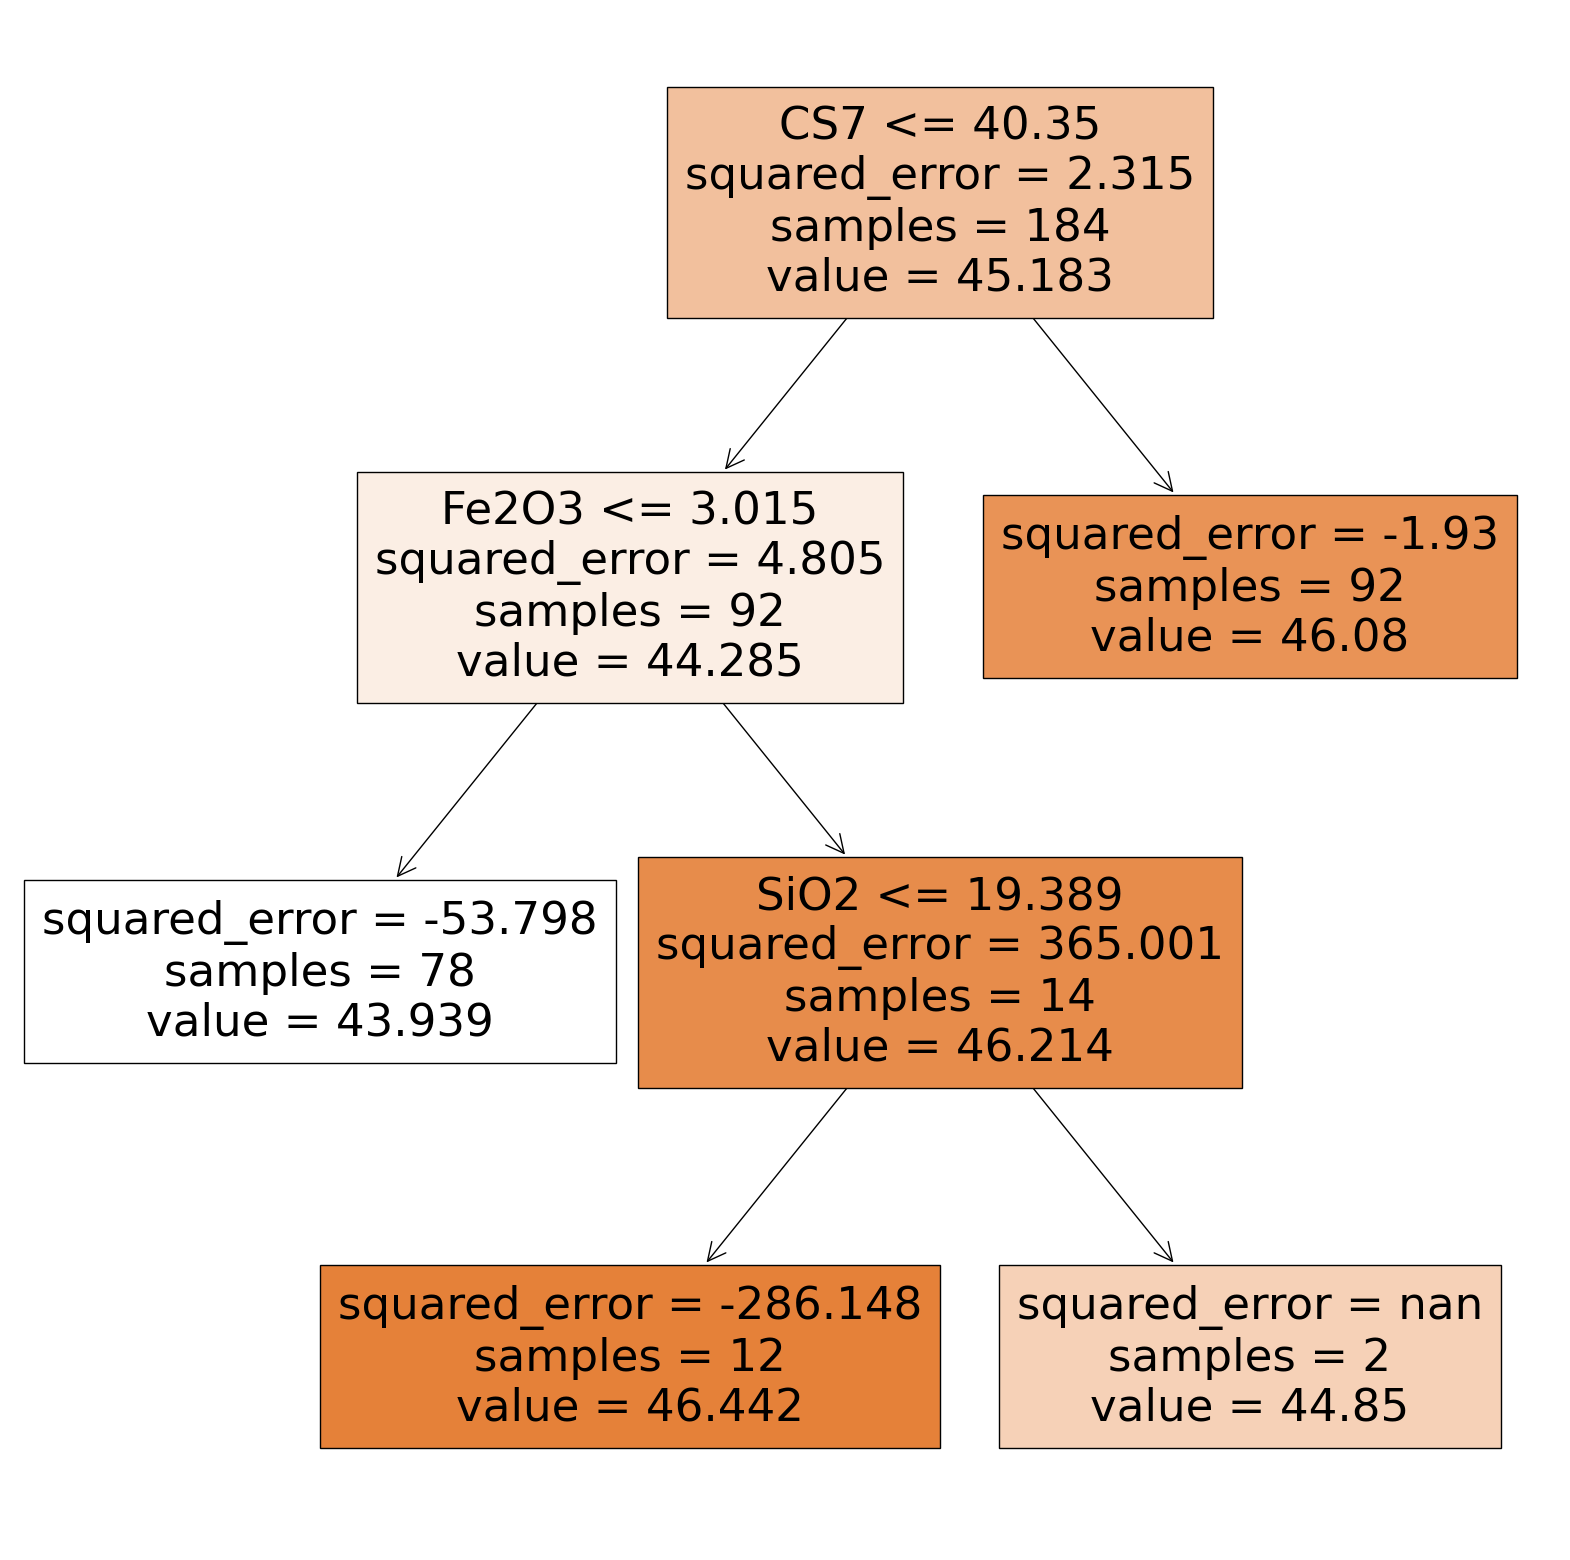

<IPython.core.display.Javascript object>

In [16]:
model = pipeline.get_params()["steps"][0][1]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
_ = plot_tree(model, filled=True, feature_names=x.columns.to_list(), ax=ax)

<Axes: >

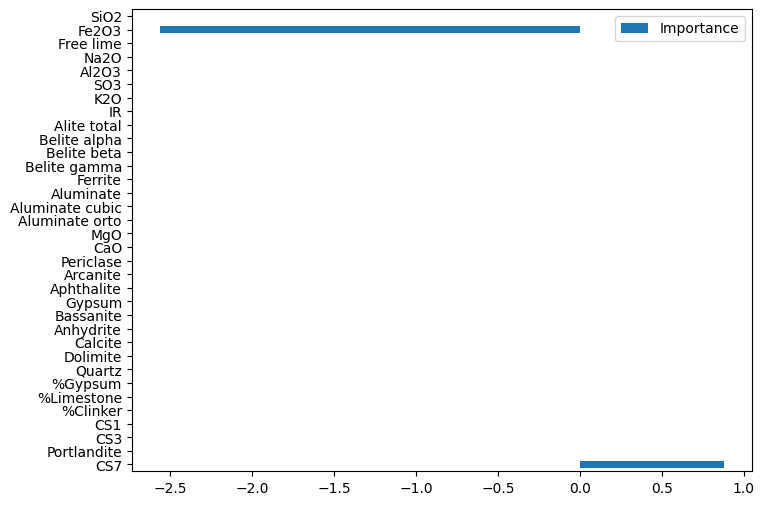

<IPython.core.display.Javascript object>

In [17]:
feat_importances = pd.DataFrame(
    model.feature_importances_, index=x.columns, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="barh", figsize=(8, 6))

In [18]:
feat_importances

,Importance
CS7,0.877786
Portlandite,0.000000
CS3,0.000000
CS1,0.000000
%Clinker,0.000000
%Limestone,0.000000
%Gypsum,0.000000
Quartz,0.000000
Dolimite,0.000000
Calcite,0.000000


<IPython.core.display.Javascript object>